In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import coreset, qaoa

np.random.seed()

In [2]:
data_vectors = np.load('Datasets/catdog_data_vectors.npy')
vector_to_label = np.load('Datasets/catdog_vector_to_label.npy', allow_pickle=True).item()

In [3]:
filtered_data_vectors = []
target_cats, target_dogs = 500, 9500
for v in data_vectors:
    if 'Cat' in vector_to_label[v.tobytes()]:
        if target_cats > 0:
            target_cats -= 1
            filtered_data_vectors.append(v)
    elif target_dogs > 0:
            target_dogs -= 1
            filtered_data_vectors.append(v)
data_vectors = np.array(filtered_data_vectors)
data_vectors = data_vectors - np.mean(data_vectors, axis=0)
np.random.shuffle(data_vectors)

In [4]:
B = coreset.get_bestB(data_vectors, num_runs=10, k=4)

cost_whole = coreset.kmeans_cost(data_vectors, coreset_vectors=data_vectors)
print('cost_whole is %s' % cost_whole)

# random sampling "coreset":
random_sample_5_list = [[data_vectors[i] for i in np.random.choice(len(data_vectors), size=5)] for _ in range(10)]
random_sample_10_list = [[data_vectors[i] for i in np.random.choice(len(data_vectors), size=10)] for _ in range(10)]
random_sample_20_list = [[data_vectors[i] for i in np.random.choice(len(data_vectors), size=20)] for _ in range(10)]
random_sample_40_list = [[data_vectors[i] for i in np.random.choice(len(data_vectors), size=40)] for _ in range(10)]
cost_5_random_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=random_sample_5_list[i]) for i in range(10)]
cost_10_random_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=random_sample_10_list[i]) for i in range(10)]
cost_20_random_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=random_sample_20_list[i]) for i in range(10)]
cost_40_random_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=random_sample_40_list[i]) for i in range(10)]
print('min cost_{5, 10, 20, 40}_random_list is %s, %s, %s, %s' % (
    np.min(cost_5_random_list), np.min(cost_10_random_list), np.min(cost_20_random_list), np.min(cost_40_random_list)))

# actual coreset:
coreset_vectors_5_list, coreset_weights_5_list = [None] * 10, [None] * 10
for i in range(10):
    coreset_vectors_5_list[i], coreset_weights_5_list[i] = coreset.BFL16(data_vectors, B=B, m=5)

coreset_vectors_10_list, coreset_weights_10_list = [None] * 10, [None] * 10
for i in range(10):
    coreset_vectors_10_list[i], coreset_weights_10_list[i] = coreset.BFL16(data_vectors, B=B, m=10)
    
coreset_vectors_20_list, coreset_weights_20_list = [None] * 10, [None] * 10
for i in range(10):
    coreset_vectors_20_list[i], coreset_weights_20_list[i] = coreset.BFL16(data_vectors, B=B, m=20)

coreset_vectors_40_list, coreset_weights_40_list = [None] * 10, [None] * 10
for i in range(10):
    coreset_vectors_40_list[i], coreset_weights_40_list[i] = coreset.BFL16(data_vectors, B=B, m=40)

cost_5_coreset_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=coreset_vectors_5_list[i], sample_weight=coreset_weights_5_list[i]) for i in range(10)]
cost_10_coreset_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=coreset_vectors_10_list[i], sample_weight=coreset_weights_10_list[i]) for i in range(10)]
cost_20_coreset_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=coreset_vectors_20_list[i], sample_weight=coreset_weights_20_list[i]) for i in range(10)]
cost_40_coreset_list = [coreset.kmeans_cost(data_vectors, coreset_vectors=coreset_vectors_40_list[i], sample_weight=coreset_weights_40_list[i]) for i in range(10)]
print('min cost_{5, 10, 20, 40}_coreset_list is %s, %s, %s, %s' % (
    np.min(cost_5_coreset_list), np.min(cost_10_coreset_list), np.min(cost_20_coreset_list), np.min(cost_40_coreset_list)))

best_index = cost_5_coreset_list.index(np.min(cost_5_coreset_list))
best_coreset_vectors = coreset_vectors_5_list[best_index]
best_coreset_weights = coreset_weights_5_list[best_index]
print('\nzeroth order for m=5 coreset:')
qaoa_bound_zero_5 = qaoa.qaoa_bound(best_coreset_vectors, best_coreset_weights, data_vectors, taylor_order=0)

best_index = cost_10_coreset_list.index(np.min(cost_10_coreset_list))
best_coreset_vectors = coreset_vectors_10_list[best_index]
best_coreset_weights = coreset_weights_10_list[best_index]

print('\nzeroth order for m=10 coreset:')
qaoa_bound_zero_10 = qaoa.qaoa_bound(best_coreset_vectors, best_coreset_weights, data_vectors, taylor_order=0)

print('\nfirst order for m=10 coreset:')
qaoa_bound_first_10 = qaoa.qaoa_bound(best_coreset_vectors, best_coreset_weights, data_vectors, taylor_order=1)

print('\nsecond order for m=10 coreset:')
qaoa_bound_second_10 = qaoa.qaoa_bound(best_coreset_vectors, best_coreset_weights, data_vectors, taylor_order=2)

print('\ninfinite order for m=10 coreset:')
qaoa_bound_inf_10 = qaoa.qaoa_bound(best_coreset_vectors, best_coreset_weights, data_vectors, taylor_order='inf')

cost_whole is 2733457.8199822353
min cost_{5, 10, 20, 40}_random_list is 3436450.762039221, 3118401.969352481, 2969017.1221628697, 2863157.537945235
min cost_{5, 10, 20, 40}_coreset_list is 3465641.202183754, 3106418.1016299147, 2976433.939240601, 2872091.6198422904

zeroth order for m=5 coreset:
3531425.924968344 (-1, 1, -1, -1, 1) 0.5821251094998363 5533552279.921874
3594807.002324426 (1, -1, 1, -1, 1) 1.1266234855673765 6288784649.238343
3600591.471639595 (1, -1, -1, 1, -1) 0.8233606862755493 7329169035.706389
3560402.7173977424 (-1, -1, 1, 1, -1) 0.8078239153289947 8445008112.341297
3611640.280520825 (1, -1, -1, -1, 1) 0.536740172519989 8125754049.750688
3557539.793367706 (1, -1, -1, -1, -1) 0.22731384580588532 7878007156.022474

zeroth order for m=10 coreset:
3128572.5345180267 (-1, -1, 1, 1, -1, -1, -1, -1, -1, 1) 0.3919588109418126 3216690512.5907974
3152447.7261680826 (-1, 1, -1, 1, -1, -1, -1, -1, 1, -1) 0.4200773376954129 3857417795.369607
3155722.729224338 (-1, 1, -1, 1, 1, 

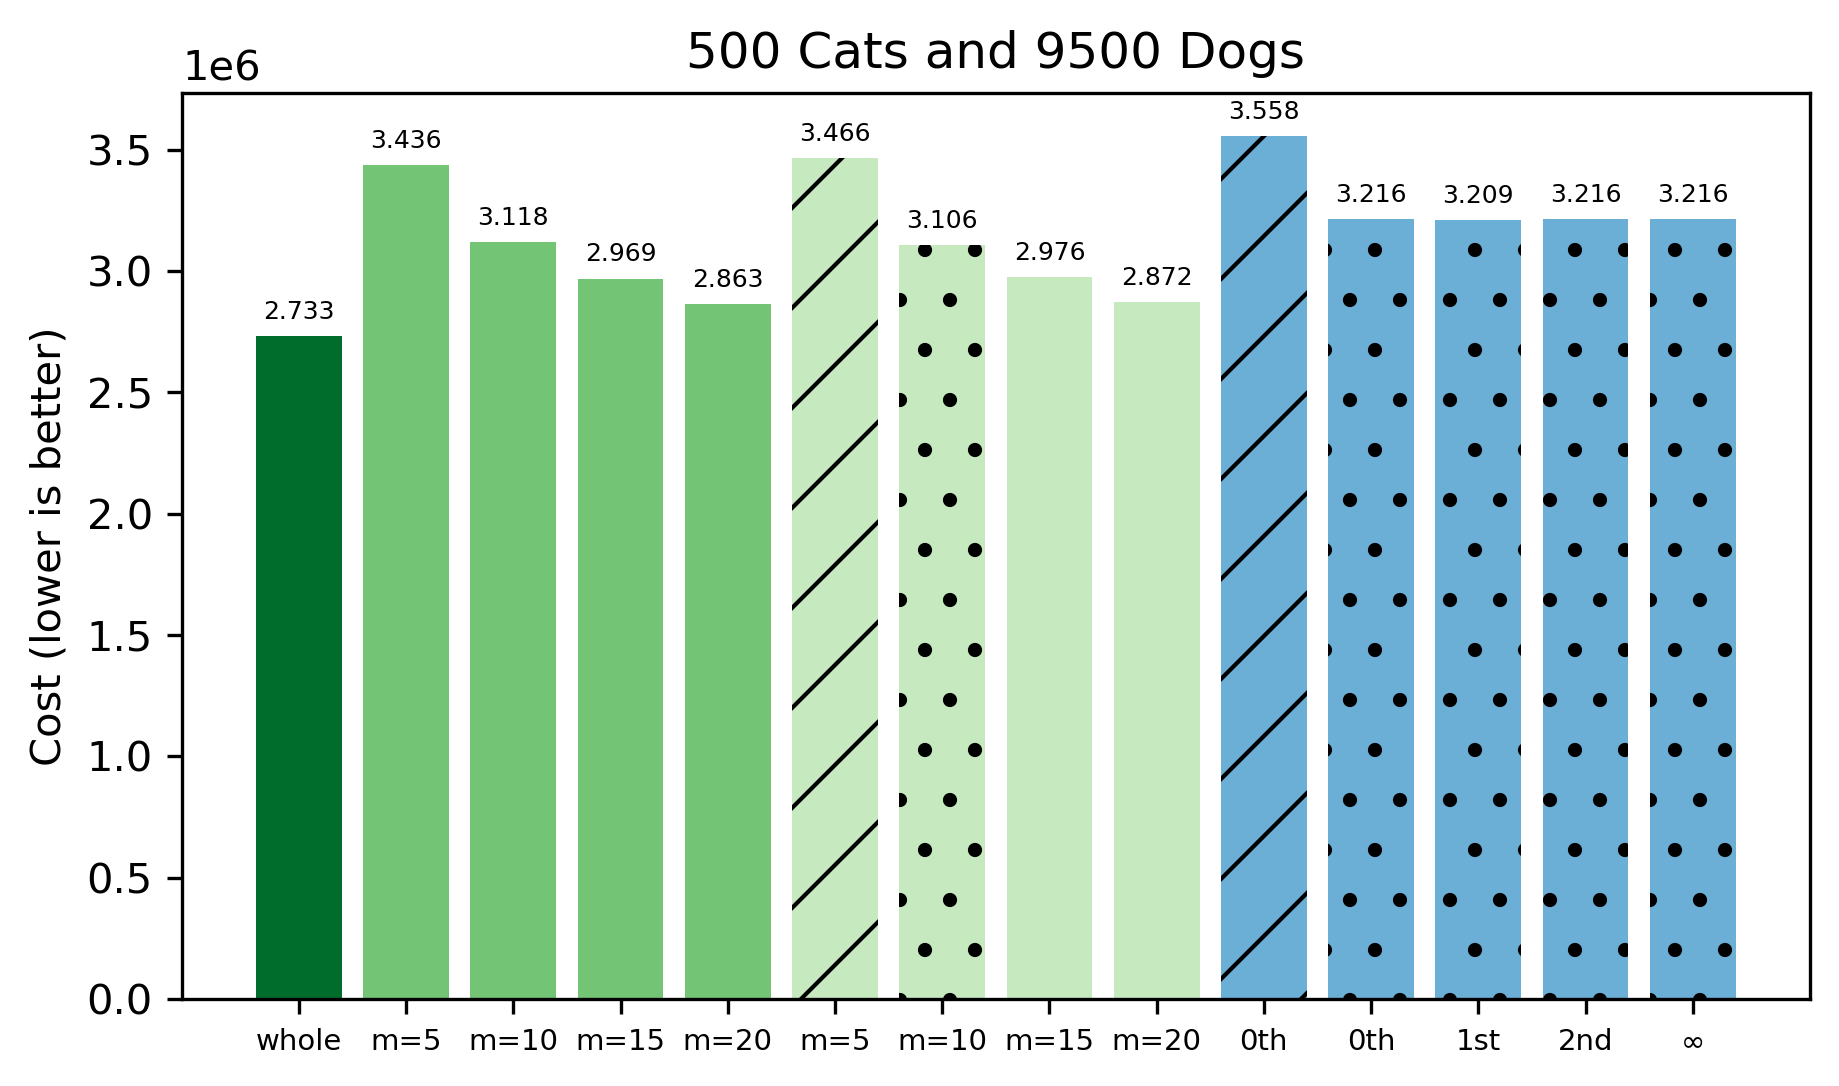

In [5]:
x = np.arange(14)
costs = [cost_whole, np.min(cost_5_random_list), np.min(cost_10_random_list), np.min(cost_20_random_list), np.min(cost_40_random_list),
         np.min(cost_5_coreset_list), np.min(cost_10_coreset_list), np.min(cost_20_coreset_list), np.min(cost_40_coreset_list),
         qaoa_bound_zero_5, qaoa_bound_zero_10, qaoa_bound_first_10, qaoa_bound_second_10, qaoa_bound_inf_10]
scale = np.floor(np.log10(max(costs)))

labels = ['whole', 'm=5', 'm=10', 'm=15', 'm=20', 'm=5', 'm=10', 'm=15', 'm=20', '0th', '0th', '1st', '2nd', u"\u221E"]
color = ['#006d2c', '#74c476', '#74c476', '#74c476', '#74c476', '#c7e9c0', '#c7e9c0', '#c7e9c0', '#c7e9c0', '#6baed6', '#6baed6', '#6baed6', '#6baed6', '#6baed6']
hatch=['', '', '', '', '', '/', '.', '', '', '/', '.', '.', '.', '.']
# plt.bar(x, costs, yerr=yerr, color=color, hatch=hatch)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height() / (10 ** scale)
        ax.annotate('{0:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height * (10 ** scale)),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=6)


fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
for i in range(len(x)):
    rects = ax.bar(x[i], costs[i], label=labels[i], color=color[i], hatch=hatch[i]) # , yerr=[[yerr[0][i]], [yerr[1][i]]])
    autolabel(rects)
    
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=7)
ax.set_ylabel('Cost (lower is better)')
ax.set_title('500 Cats and 9500 Dogs')

plt.savefig('catdog.pdf')

In [6]:
len(data_vectors)

10000